In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import load_model
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load your dataset
df = pd.read_csv('dic1985-oct2025.csv')

# 1. Data Preprocessing
print("Dataset types:", df.describe)
print("\nDataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Convert date to datetime and set as index
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Dataset types: <bound method NDFrame.describe of                            fecha   temp_max   temp_min  presion_max  \
0      1985-12-12 06:00:00+00:00  21.357500   6.807500    788.17240   
1      1985-12-13 06:00:00+00:00  21.807500   9.307501    788.45910   
2      1985-12-14 06:00:00+00:00  18.707500   8.307501    791.04956   
3      1985-12-15 06:00:00+00:00  19.507500   6.957500    790.46080   
4      1985-12-16 06:00:00+00:00  17.957500   8.057501    789.69550   
...                          ...        ...        ...          ...   
14547  2025-10-10 06:00:00+00:00  21.337000  13.137000    790.36800   
14548  2025-10-11 06:00:00+00:00  21.536999  12.537001    789.20233   
14549  2025-10-12 06:00:00+00:00  23.237000  13.687000    787.04200   
14550  2025-10-13 06:00:00+00:00  23.737000  10.437000    787.70966   
14551  2025-10-14 06:00:00+00:00  22.637000  10.937000    789.29800   

       presion_min  rocio_max  rocio_min  viento_promedio  radiacion  \
0        780.33673   8.407

In [50]:
df.shape

(14552, 9)

In [51]:
# Feature selection (excluding target)
features = ['temp_max', 'temp_min', 'presion_max', 'presion_min', 
        'rocio_max', 'rocio_min', 'viento_promedio', 'radiacion']
target = 'precipitacion_total'

# 2. Data Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scale features
X_scaled = scaler_x.fit_transform(df[features])
# Scale target
y_scaled = scaler_y.fit_transform(df[[target]])

In [52]:
# 3. Create sequences for LSTM
def create_sequences(X, y, time_steps=30):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define time steps (using 30 days of historical data)
TIME_STEPS = 30
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"\nSequences shape: X={X_sequences.shape}, y={y_sequences.shape}")



Sequences shape: X=(14522, 30, 8), y=(14522, 1)


In [53]:
# 4. Train-Test Split (chronological split)
split_ratio = 0.8
split_index = int(len(X_sequences) * split_ratio)

X_train = X_sequences[:split_index]
X_test = X_sequences[split_index:]
y_train = y_sequences[:split_index]
y_test = y_sequences[split_index:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (11617, 30, 8), (11617, 1)
Test set: (2905, 30, 8), (2905, 1)


In [72]:
# 5. Build LSTM Model
model  = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, len(features))))

model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))

model.add(Dropout(0.3))

model.add(LSTM(96, return_sequences=True))

model.add(Dropout(0.3))

model.add(LSTM(96, return_sequences=True))

model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))

model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False))

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))

model.add(Dropout(0.3))

model.add(Dense(1))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='mse', 
              metrics=['mae'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 30, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 30, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 30, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,593 (1.67 MB)

 Trainable params: 438,593 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, len(features))),
    Dropout(0.3),
    LSTM(50, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='mse', 
              metrics=['mae'])

print("\nModel Summary:")
model.summary()

In [78]:
# 6. Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False  # Important for time series data
)

Epoch 1/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6111 - mae: 0.3976 - val_loss: 1.7584 - val_mae: 0.6843
Epoch 2/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6092 - mae: 0.3965 - val_loss: 1.7503 - val_mae: 0.6826
Epoch 3/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6057 - mae: 0.3973 - val_loss: 1.7439 - val_mae: 0.6830
Epoch 4/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6076 - mae: 0.3969 - val_loss: 1.7471 - val_mae: 0.6833
Epoch 5/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6087 - mae: 0.3977 - val_loss: 1.7450 - val_mae: 0.6813
Epoch 6/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6114 - mae: 0.3971 - val_loss: 1.7530 - val_mae: 0.6825
Epoch 7/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6060 - mae: 0.3966 - val_loss: 1.7488 - val_mae: 0.6829
Epoch 8/300
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6039 - mae: 0.3967 - val_loss: 1.7294 - val_mae: 0.6818
Epoch 9/300
364/364 ━━━━━━━━━━━━━━━━━━━━

In [79]:
# 7. Evaluate the Model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTraining Loss: {train_loss[0]:.4f}, MAE: {train_loss[1]:.4f}")
print(f"Test Loss: {test_loss[0]:.4f}, MAE: {test_loss[1]:.4f}")


Training Loss: 0.5962, MAE: 0.3998
Test Loss: 1.7294, MAE: 0.6818


In [80]:
# 8. Make Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [85]:
print(y_pred)
print(y_actual)

[[1.3109931]
 [1.3194977]
 [1.3570243]
 ...
 [5.275879 ]
 [5.219463 ]
 [5.176436 ]]
[[5.4999995 ]
 [0.8       ]
 [0.        ]
 ...
 [0.2       ]
 [0.70000005]
 [0.        ]]


In [81]:
# Calculate metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mse)

print(f"\nPerformance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Performance Metrics:
Mean Squared Error: 28.5954
Mean Absolute Error: 2.7724
Root Mean Squared Error: 5.3475


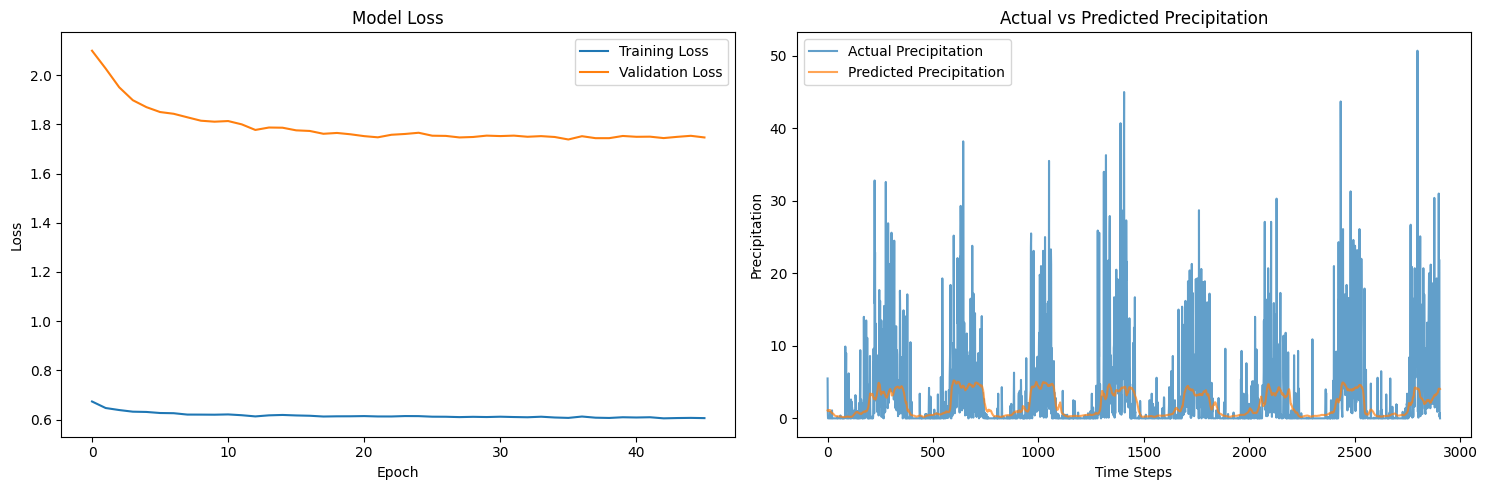

In [77]:
# 9. Plot Results
plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(y_actual, label='Actual Precipitation', alpha=0.7)
plt.plot(y_pred, label='Predicted Precipitation', alpha=0.7)
plt.title('Actual vs Predicted Precipitation')
plt.xlabel('Time Steps')
plt.ylabel('Precipitation')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# 10. Feature Importance Analysis (Optional)
# Get the last layer weights to understand feature importance
print("\nFeature names:", features)

# 11. Save the Model
model.save('rainfall_prediction_lstm3.keras')
print("\nModel saved as 'rainfall_prediction_lstm3.keras'")



Feature names: ['temp_max', 'temp_min', 'presion_max', 'presion_min', 'rocio_max', 'rocio_min', 'viento_promedio', 'radiacion']

Model saved as 'rainfall_prediction_lstm2.keras'


In [7]:
# Function to make future predictions
def predict_future(model, last_sequence, days=7):
    """
    Predict future precipitation for specified number of days
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, TIME_STEPS, len(features)))
        future_predictions.append(next_pred[0, 0])
        
        # Update sequence (remove first, add prediction)
        current_sequence = np.roll(current_sequence, -1, axis=0)
        # For the new row, we need to create a dummy row with the prediction
        # In practice, you'd need actual feature values for future dates
        new_row = np.zeros(len(features))
        # This is simplified - you'd need a better approach for real future predictions
        current_sequence[-1] = new_row
    
    future_predictions = scaler_y.inverse_transform(
        np.array(future_predictions).reshape(-1, 1)
    )
    return future_predictions


In [ ]:

# Example of future prediction (using the last sequence from test set)
if len(X_test) > 0:
    last_sequence = X_test[-1]
    future_pred = predict_future(model, last_sequence, days=7)
    print(f"\nNext 7 days precipitation predictions:")
    for i, pred in enumerate(future_pred, 1):
        print(f"Day {i}: {pred[0]:.2f} mm")

In [ ]:
not_last_sequence = y_test[-2]
for i, pred in enumerate(not_last_sequence, 1):
    print(f"Day {i}: {pred[0]:.2f} mm")

future_pred_2 = predict_future(model, last_sequence, days=30)
print(f"\nNext 7 days precipitation predictions:")
for i, pred in enumerate(future_pred_2, 1):
        print(f"Day {i}: {pred[0]:.2f} mm, Real: {not_last_sequence[i-1][0]:.2f} mm")

Day 1: 0.09 mm
Day 2: 0.14 mm
Day 3: 0.16 mm
Day 4: 0.08 mm
Day 5: -0.16 mm
Day 6: 0.19 mm
Day 7: 0.61 mm
Day 8: 0.30 mm
Day 9: 0.56 mm
Day 10: 0.78 mm
Day 11: 1.23 mm
Day 12: 0.62 mm
Day 13: -0.42 mm
Day 14: -0.10 mm
Day 15: -0.00 mm
Day 16: -0.07 mm
Day 17: -0.51 mm
Day 18: -0.08 mm
Day 19: 0.09 mm
Day 20: -0.08 mm
Day 21: -0.00 mm
Day 22: -0.77 mm
Day 23: -0.32 mm
Day 24: -0.34 mm
Day 25: 0.27 mm
Day 26: -1.70 mm
Day 27: -0.59 mm
Day 28: -0.29 mm
Day 29: -0.23 mm
Day 30: 0.32 mm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━

In [6]:
modelo = load_model("rainfall_prediction_lstm2.keras")

I0000 00:00:1760598044.830132   49354 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7346 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [27]:
y_test.shape

y_test_sin = scaler_y.inverse_transform(y_test)
X_test[-1].shape

(30, 8)

In [46]:
not_last_sequence = scaler_y.inverse_transform(y_test).tolist()
not_last_sequence = not_last_sequence[-30:]
print(not_last_sequence)
print(len(not_last_sequence))
for i, pred in enumerate(not_last_sequence, 1):
    print(f"Day {i}: {pred[0]:.2f} mm")

last_sequence = X_test[-1]

future_pred_2 = predict_future(modelo, last_sequence, days=30)
print(f"\nNext 7 days precipitation predictions:")
for i, pred in enumerate(future_pred_2, 1):
        print(f"Day {i}: {pred[0]:.2f} mm, Real: {not_last_sequence[i-1][0]:.2f} mm")

[[2.6000001], [18.800001], [30.399998], [3.8999999], [1.5], [13.900001], [3.7], [2.5], [2.7], [17.4], [4.7], [12.5], [10.900001], [19.3], [15.900000000000002], [8.400001], [0.9000001], [12.5], [1.8000001], [1.9000001], [4.2], [12.0], [4.9], [31.0], [7.5], [21.900002], [9.6], [0.19999999999999996], [0.7000000499999999], [0.0]]
30
Day 1: 2.60 mm
Day 2: 18.80 mm
Day 3: 30.40 mm
Day 4: 3.90 mm
Day 5: 1.50 mm
Day 6: 13.90 mm
Day 7: 3.70 mm
Day 8: 2.50 mm
Day 9: 2.70 mm
Day 10: 17.40 mm
Day 11: 4.70 mm
Day 12: 12.50 mm
Day 13: 10.90 mm
Day 14: 19.30 mm
Day 15: 15.90 mm
Day 16: 8.40 mm
Day 17: 0.90 mm
Day 18: 12.50 mm
Day 19: 1.80 mm
Day 20: 1.90 mm
Day 21: 4.20 mm
Day 22: 12.00 mm
Day 23: 4.90 mm
Day 24: 31.00 mm
Day 25: 7.50 mm
Day 26: 21.90 mm
Day 27: 9.60 mm
Day 28: 0.20 mm
Day 29: 0.70 mm
Day 30: 0.00 mm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s